In [18]:
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from utils import gradient_descent, gradientDescentReg, predict_proba, polyFeatureVector

# Part 5 ~ Iris dataset
multi-class - one-vs-all - logistic regression

<Figure size 800x600 with 0 Axes>

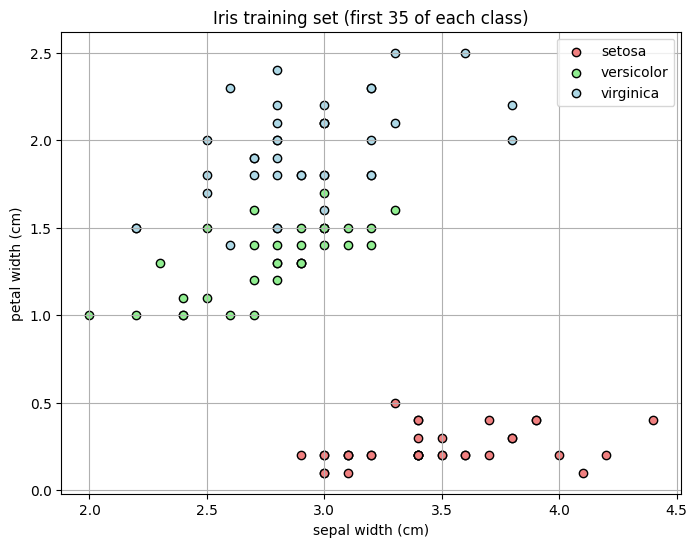

In [12]:
# ~ A ~ #
iris = datasets.load_iris()
sepw = np.array(iris.data[:, 1])
petw = np.array(iris.data[:, 3])
X = np.array([sepw, petw]).T

y = iris.target.reshape(-1,1)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
plt.figure(2, figsize=(8, 6))
plt.clf()

idx_setosa = np.arange(0, 35)
idx_versicolor = np.arange(50, 85)
idx_virginica = np.arange(100, 135)

X_s = X[idx_setosa]
X_v = X[idx_versicolor]
X_vi = X[idx_virginica]

plt.figure(figsize=(8, 6))
plt.scatter(X_s[:, 0],  X_s[:, 1],color='lightcoral', label='setosa',edgecolor='k')
plt.scatter(X_v[:, 0],  X_v[:, 1],color='lightgreen',label='versicolor',edgecolor='k')
plt.scatter(X_vi[:, 0], X_vi[:, 1], color='lightblue', label='virginica', edgecolor='k')

plt.xlabel('sepal width (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris training set (first 35 of each class)')
plt.legend()
plt.grid()
plt.show()


In [13]:
# ~ B ~ #
def fit_iris_models(X, y, degree_for_versicolor=4, lambda_=0.0, alpha=0.1, num_iters=1000):
    """
    train one-vs-all logistic-regression models on X,y.
    uses a polynomial expansion of given degree only for class==1.
    returns a dict with:
      - thetas: {class_label: theta_vector}
      - preds:  predicted labels (shape m,)
      - accuracy: overall training accuracy (%)
      - cm: confusion matrix (3×3 array)
      - report: classification report string
    """
    m = X.shape[0]
    classes = np.unique(y.flatten())
    thetas = {}

    for k in classes:
        # binary target for this class
        y_k = (y.flatten() == k).astype(int).reshape(-1,1)

        if k == 1:
            # versicolor: polynomial features
            X_k = polyFeatureVector(X[:,0], X[:,1], degree_for_versicolor)
        else:
            # other classes: linear + bias
            X_k = np.concatenate([np.ones((m,1)), X], axis=1)

        theta0 = np.zeros((X_k.shape[1], 1))

        if lambda_ > 0: # choose regularized or vanilla gradient descent
            theta_k, _ = gradientDescentReg(X_k, y_k, theta0, alpha, num_iters, lambda_)
        else:
            theta_k, _ = gradient_descent(X_k, y_k, theta0, alpha, num_iters)

        thetas[int(k)] = theta_k

    probs = np.zeros((m, len(classes)))
    for k in classes: # calculate probs for each classifier
        theta_k = thetas[int(k)]
        if k == 1:
            X_k = polyFeatureVector(X[:,0], X[:,1], degree_for_versicolor)
        else:
            X_k = np.concatenate([np.ones((m,1)), X], axis=1)
        probs[:, int(k)] = predict_proba(X_k, theta_k).flatten()

    preds = np.argmax(probs, axis=1)
    acc = np.mean(preds == y.flatten()) * 100
    cm = confusion_matrix(y.flatten(), preds)
    report = classification_report(y.flatten(), preds, target_names=['setosa','versicolor','virginica'])

    return {'thetas': thetas, 'preds': preds, 'accuracy': acc, 'cm': cm, 'report': report}


def plot_iris_decision_boundaries(results, X, y, degree_for_versicolor=4, grid_size=200):
    """
    plot decision boundaries for each class using thetas from classifiers results.
    produces one figure per class.
    """
    m = X.shape[0]
    classes = sorted(results['thetas'].keys())
    thetas = results['thetas']

    u = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, grid_size)
    v = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, grid_size)
    U, V = np.meshgrid(u, v)

    for k in classes:
        plt.figure(figsize=(6,5))
        theta_k = thetas[k]
        y_k = (y.flatten() == k).astype(int)

        if k == 1:
            # compute Z over the grid for polynomial boundary
            Z = np.zeros(U.shape)
            for i in range(U.shape[0]):
                for j in range(U.shape[1]):
                    vec = polyFeatureVector(np.array([U[i,j]]), np.array([V[i,j]]), degree_for_versicolor)
                    Z[i,j] = vec.dot(theta_k).flatten()
            plt.contour(u, v, Z, levels=[0], linewidths=2, colors='purple')
        else:
            # linear boundary: solve theta0 + theta1*x + theta2*y = 0
            x_min, x_max = u.min(), u.max()
            theta0, theta1, theta2 = theta_k.flatten()
            y_min = -(theta0 + theta1*x_min) / theta2
            y_max = -(theta0 + theta1*x_max) / theta2
            plt.plot([x_min, x_max], [y_min, y_max], 'b-', label='decision boundary')

        plt.scatter(X[y_k==0,0], X[y_k==0,1], c='lightgray', edgecolor='k', label=f'rest')
        plt.scatter(X[y_k==1,0], X[y_k==1,1], c='lightblue', edgecolor='k', label=f'class={k+1}')

        plt.xlabel('sepal width (cm)')
        plt.ylabel('petal width (cm)')
        plt.title(f'decision boundary for class {k+1}')
        plt.legend()
        plt.grid()


    plt.show()

training accuracy: 96.67%
confusion matrix:
 [[50  0  0]
 [ 0 48  2]
 [ 0  3 47]]
classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.94      0.96      0.95        50
   virginica       0.96      0.94      0.95        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



C:\Users\eb300\AppData\Local\Temp\ipykernel_2032\96525036.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = vec.dot(theta_k).flatten()


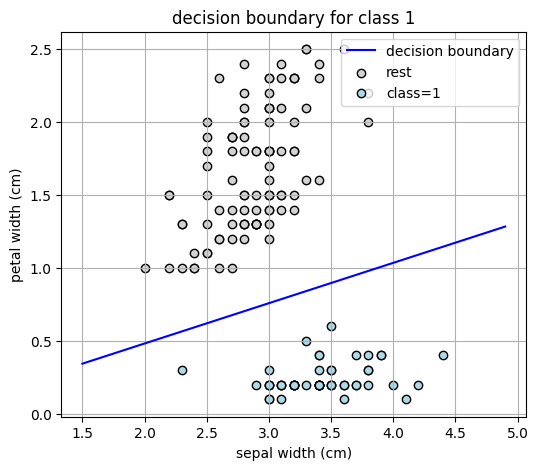

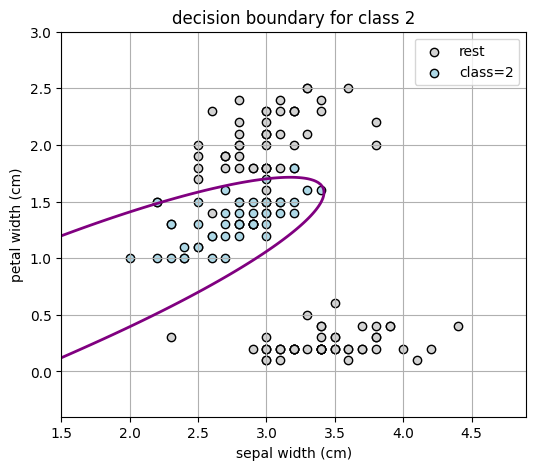

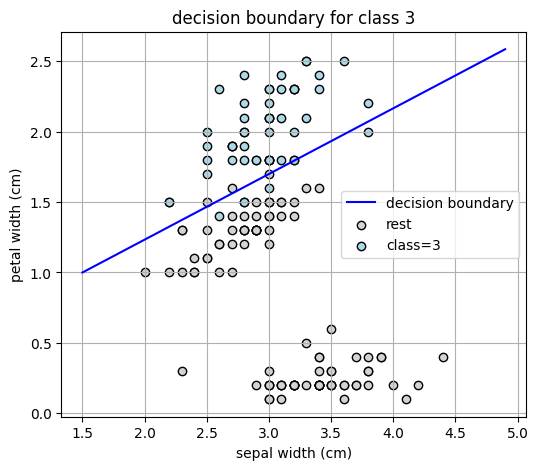

In [14]:
# ~ C ~ #
results = fit_iris_models(X, y, degree_for_versicolor=4, lambda_=0.0, alpha=0.1, num_iters=1000)

print(f"training accuracy: {results['accuracy']:.2f}%")
print("confusion matrix:\n", results['cm'])
print("classification report:\n", results['report'])

plot_iris_decision_boundaries(results, X, y, degree_for_versicolor=4)

In [15]:
# ~ D ~ #
def evaluate_on_test_set(thetas, X_test, y_test, degree_for_versicolor=4):
    """
    Given the trained thetas dict, compute predicted labels on X_test.
    """
    m_test = X_test.shape[0]
    n_classes = len(thetas)
    probs = np.zeros((m_test, n_classes))

    for k, theta_k in thetas.items():
        if k == 1:
            Xk = polyFeatureVector(X_test[:,0], X_test[:,1], degree_for_versicolor)
        else:
            Xk = np.concatenate([np.ones((m_test,1)), X_test], axis=1)
        probs[:, k] = predict_proba(Xk, theta_k).flatten()

    y_pred = np.argmax(probs, axis=1)

    n_correct = int((y_pred == y_test.flatten()).sum())
    accuracy_pct = 100 * n_correct / m_test

    return n_correct, accuracy_pct

In [16]:
# ~ D ~ #
X = iris.data[:, [1, 3]]   
y = iris.target.reshape(-1, 1) 

test_idx = np.concatenate([np.arange(36, 50), np.arange(86, 100),  np.arange(136, 150)])

all_idx   = np.arange(X.shape[0])
train_idx = np.setdiff1d(all_idx, test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

results = fit_iris_models( X_train, y_train,degree_for_versicolor=4, lambda_=0.0, alpha=0.1, num_iters=1000)
thetas = results['thetas']

n_correct, accuracy = evaluate_on_test_set(thetas, X_test, y_test, degree_for_versicolor=4)

total = X_test.shape[0]
print(f"{n_correct} out of {total} samples classified correctly")
print(f"Test accuracy: {accuracy:.2f}%")


41 out of 42 samples classified correctly
Test accuracy: 97.62%


In [17]:
# ~ E ~ #
X = iris.data[:, [1, 3, 0, 2]]  # [sepal width, petal width, sepal length, petal length]
y = iris.target.reshape(-1,1)

idx_train = np.concatenate([np.arange(0, 35),  np.arange(50, 85), np.arange(100,135)])
idx_test = np.concatenate([ np.arange(35, 50), np.arange(85,100), np.arange(135,150)])

X_train, y_train = X[idx_train], y[idx_train]
X_test,  y_test  = X[idx_test],  y[idx_test]

results = fit_iris_models( X_train, y_train, degree_for_versicolor=4, lambda_=0.3, alpha=0.1, num_iters=1000)
thetas = results['thetas']

n_correct, accuracy = evaluate_on_test_set( thetas, X_test, y_test, degree_for_versicolor=4)

total = X_test.shape[0]
print(f"{n_correct}/{total} correct → test accuracy = {accuracy:.2f}%")

44/45 correct → test accuracy = 97.78%
